## Importing packages, loading data

In [1]:
# neccessities for the project setup
# this enables automatic reload of the libraries specific to this project
%load_ext autoreload
%autoreload 1

import multiprocessing as mp
import os
import sys

# fs_utils.py stores paths to every other directory in the projects
# this module is located at the top level of the repository
# jupyter can't see it unless I change the cwd manually
# official man page tells that it's not actually possible in any other way
sys.path.append(os.path.abspath(".."))
%aimport fs_utils

# extend != append, the former appends the content while 
# the latter — the list with two elements...
os.chdir(fs_utils.ROOT_DIR)
sys.path.extend([fs_utils.LIB_DIR, fs_utils.ROOT_DIR, fs_utils.SRC_DIR])

In [2]:
# standard library
import gc
import pickle
gc.enable()

In [3]:
# third-party modules
from collections import defaultdict
from joblib import Parallel, delayed
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import scipy.stats as sps
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook

%matplotlib inline

In [4]:
# custom modules
%aimport util
%aimport qtls

In [8]:
qtls_df = {
    "eQTLs_2011" : {
        "naive" : pd.read_table("./data/processed/eQTLs/2011/qtls_naive.csv"),
        "limix" : pd.read_table("./data/processed/eQTLs/2011/qtls_limix.csv")
    },
    "eQTLs_2018" : { 
        "A&B" : pd.read_table("./data/processed/eQTLs/2018/qtls_albert&bloom_from_paper.csv"),
        "limix" : pd.read_table("./data/processed/eQTLs/2018/qtls_limix.csv")
    }, 
    "pQTLs_2011" : {
        "naive" : pd.read_table("./data/processed/pQTLs/2011/qtls_naive.csv"),
        "limix" : pd.read_table("./data/processed/pQTLs/2011/qtls_limix.csv")
    }
}
qtls_df["eQTLs_2011"]["naive"]["score"] = qtls_df["eQTLs_2011"]["naive"]["q_value"]
qtls_df["pQTLs_2011"]["naive"]["score"] = qtls_df["pQTLs_2011"]["naive"]["q_value"]
qtls_df["eQTLs_2018"]["A&B"]["score"] = (1 - MinMaxScaler()\
                                               .fit_transform(
                                                    qtls_df["eQTLs_2018"]["A&B"]["LOD"].values[:,None]
                                                )
                                          )
for qtl_type in ["eQTLs_2011", "eQTLs_2018", "pQTLs_2011"]:
    qtls_df[qtl_type]["limix"]["score"] = qtls_df[qtl_type]["limix"]["q_value"]

# Physical and genetic interactions taken from TheBioGrid project
interactome_df = pd.read_table("./data/raw/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[
#     full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association", 
    "colocalization", 
    "direct interaction",
    "physical association"
]

In [9]:
interaction_categories = physical_interaction_categories
interactome_df.set_index('Interaction Type', inplace=True)

genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

interaction_categories = (genetic_interaction_categories 
                          + physical_interaction_categories 
                          + ["all", "physical", "genetic"])

def extract_interactions(interactions_df):
    ''' Helper function to retrieve the edges of the graph of interactions '''
    return interactions_df[["Interactor A", "Interactor B"]].values

type2interactome = {}
for edge_type in interaction_categories:
    with open("./data/raw/interactions/{}_interactions_graph.pkl".format(edge_type), "rb") as infile:
        type2interactome[edge_type] = pickle.load(infile)

## Implementation

**Introduction — interacting vs. random:**  
*“Interacting genes share more linkages than expected at random”*  

- For each edge, compute the Jaccard coefficient of the sets of markers linked to its endpoints. 
- Then generate the same number of random gene pairs, compute the coefficients. 
- Repeat a few thousand times and average the results. 

Compare distributions of Jaccard coefficients through such statistics, as:

- p-value from MWU test
- mean value
- confidence intervals

A class generating this figure must reside in `qtls` module and be well-documented. 
Let's call it `RandomPairsTest`.

In [13]:
# Было бы очень неплохо добавить автоматические дампы.
# Скажем, с каким-то шагом пиклить целиком весь класс.
# Это реализовано из коробки в каком-нибудь пакете?

class RandomPairsTest:
    """
    Given a list of QTLs as (marker, gene) pairs and a graph of interactions,
    traverses all of its edges and calculates on the way the Jaccard similarity between
    sets of markers linked to edge's endpoints. When done, generates |E| random edges,
    repeats the same computation. Two distributions — from actual and random edges — 
    are then compared by test statistics (mean value, confidence intervals etc).
    -----------------------------------------------------------------------------------
    This class was designed with map-reduce paradigm in mind. 
    """
    def __init__(self, interactome, qtls_df, score_thresholds, max_iter, n_jobs=-1):
        assert "SNP" in qtls_df.columns, "provided QTLs don't have marker column"
        assert "gene" in qtls_df.columns, "provided QTLs don't have gene column"
        assert "score" in qtls_df.columns, "provided QTLs don't have associated scores"
        assert np.all((0 <= qtls_df["score"]) & (qtls_df["score"] <= 1)),\
                "scores must be scaled to fit into (0, 1) range"
        assert np.all((0 <= score_thresholds) & (score_thresholds <= 1)),\
                "some thresholds are outside (0, 1) range"
        
        self.interactome = interactome
        self.qtls_df = qtls_df
        self.score_thresholds = score_thresholds
        self.max_iter = max_iter
        
        self.n_edges = self.interactome.ecount()
        self.n_nodes = self.interactome.vcount()
        self.node_names = self.interactome.vs["name"]

        self.edges = [
            (self.node_names[e.source], self.node_names[e.target])
            for e in self.interactome.es
        ]
        
        self.n_jobs = n_jobs if n_jobs > 0 else mp.cpu_count()
        self.simulation_results = defaultdict(list)
    
    @staticmethod
    def jaccard_from_edge(edge, gene2linked_markers):
        """
        -----------------------------------------
        @param edge — (str, str) — tuple of nodes
        @param gene2linked_markers — dict(str, list[str])
            maps gene name into the list of 
            markers linked to that gene
        -----------------------------------------
        @note   returns -1 if both endpoints have 
                no markers linked to them
        """
        source, target = edge
        if (not gene2linked_markers[source].size 
            and not gene2linked_markers[target].size): return -1 
        
        return qtls.jaccard(set(gene2linked_markers[source]), 
                            set(gene2linked_markers[target]))
    
    @staticmethod
    def linkage_similarity(edges_list, gene2linked_markers):    
        """
        Jaccard similarity computation for each of the edges.
        ------------------------------------------------------
        @param edges_list — list[(str, str)]
        @param gene2linked_markers — dict(str, list[str])
            maps gene name into the list of 
            markers linked to that gene
        """
        jaccard = np.fromiter((RandomPairsTest.jaccard_from_edge(edge, gene2linked_markers)
                               for edge in edges_list), dtype=np.float32)
        return jaccard[jaccard >= 0]
    
    
    @staticmethod
    def process_threshold(thresh, edges_list, node_names, qtls_df, max_iter):
        """
        QTL filtering and Jaccard coefficient computation.
        ----------------------------------------------------------
        @param thresh — float — score cutoff
        @param edges_list — list(str)
            list of edges given as pairs of gene names
        @param node_names — list(str)
            list of gene names corresponding to the 
            nodes of the interactome graph
        @param qtls_df — pd.DataFrame
            must contain such columns as ["SNP", "gene", "score"]
        @param max_iter — int — number of randomization iterations
        ----------------------------------------------------------
        @returns    a dictionary with:
                    — mean jaccard similarity 
                      (for real interactome and for each simulation)
                    — list of p-values obtained through;
                      MWU test that compared the actual Jaccard 
                      coefficient distribution with those arising
                      during simulation runs;
                    — number of edges with at least one linked 
                      marker with score below current threshold.
        ----------------------------------------------------------
        @note   staticmethod decorator makes this method 
                compatible with joblib (or multiprocessing module)
        """
        
        signif_qtls_df = qtls_df[qtls_df["score"] <= thresh]
        gene2linked_markers = {v : qtls.linked_markers(signif_qtls_df, v)
                               for v in node_names}
        
        # It's possible to manually remove the nodes without linkages
        # by taking a subgraph of the interactome graph.  
        # This may lead to considerable increase in performance.
        # But we only need to run this test once on a compute node,
        # thereby this optimization is not going to be implemented.
        
        n_nodes = len(node_names)
        n_edges = len(edges_list)
        
        random_edges = [
            [(node_names[u], node_names[v]) 
            for u, v in util.sample_combinations(
                (n_nodes, n_nodes), 
                n_edges
            )]
            for _ in range(max_iter)
        ]
            
        linksim = {
            "actual" : RandomPairsTest.linkage_similarity(
                edges_list, 
                gene2linked_markers
            ),
            "random" : [
                RandomPairsTest.linkage_similarity(
                    random_edges[i], 
                    gene2linked_markers
                    
                ) for i in range(max_iter)
            ]
        }
        
        p_values = []
        for i in range(max_iter):
            try:
                p_values.append(
                    sps.mannwhitneyu(linksim["actual"], 
                                     linksim["random"][i], 
                                     alternative="two-sided")[1]
                )
            except ValueError: # "all numbers are idential in mannwhitneyu"
                p_values.append(1)
            
        
        simulation_results = {
            "actual-mean-linksim" : np.mean(linksim["actual"]),
            "random-mean-linksim" : [np.mean(randiter) for randiter in linksim["random"]],
            "p-value" : [sps.combine_pvalues(p_values)[1]], # not sure on this method choice
            "actual-edge-has-linkages" : len(linksim["actual"]),
            "random-edge-has-linkages" : [len(linksim["random"][i]) 
                                          for i in range(max_iter)]
        }
        del gene2linked_markers, linksim, signif_qtls_df        
        return simulation_results

    def map(self):
        """
        Computes the averaged Jaccard similarity for real interactome.
        Then simulates self.max_iter random lists of edges and 
        repeats the computations with those. 
        
        Method's name comes form the fact that it distributes the
        simulation iterations among workers on cluster.
        --------------------------------------------------------------
        @returns None (results are stored at self.simulation_results)
        """
        mapped = \
            Parallel(n_jobs=self.n_jobs)(
                delayed(RandomPairsTest.process_threshold)(
                    thresh, self.edges, self.node_names, 
                    self.qtls_df, self.max_iter
                )
                for thresh in self.score_thresholds
            )
        
        for test_stat in ["actual-mean-linksim", "p-value", "actual-edge-has-linkages"]:
            self.simulation_results[test_stat] = np.concatenate([np.atleast_1d(run[test_stat]) 
                                                                 for run in mapped])
            
        for test_stat in ["random-mean-linksim", "random-edge-has-linkages"]:    
            self.simulation_results[test_stat] = np.vstack([run[test_stat] 
                                                            for run in mapped])
        
    def reduce(self, summarize=True):
        """
        Summarizes the self.simulation_results when asked to do so
        """
        if summarize:
            mapped = self.simulation_results # for brevity
            simulation_summary = {
                "linksim" : {
                    key : 
                    np.quantile(mapped["random-mean-linksim"], val, axis=1)
                    for key, val in zip(["25%", "50%", "75%"], 
                                        [0.25, 0.5, 0.75])
                },
                "edge-has-linkages" : {
                    key : 
                    np.quantile(mapped["random-edge-has-linkages"], val, axis=1)
                    for key, val in zip(["25%", "50%", "75%"], 
                                        [0.25, 0.5, 0.75])
                }
            }
            actual_summary = {
                "linksim" : { "mean" : mapped["actual-mean-linksim"] },
                "edge-has-linkages" : { "mean" : mapped["actual-edge-has-linkages"] }
            }
            return {"actual" : actual_summary, 
                    "p-value" : mapped["p-value"],
                    "random" : simulation_summary}
        return self.simulation_results
    
    def map_reduce(self, summarize=True):
        """
        Master-function that initiates the pipeline.
        """
        self.map()
        return self.reduce(summarize)

## Running the test suite on Albert&Bloom's eQTLs. 

Works like a charm. As test requires a `score` feature, I applied min-max normalization to LOD scores provided in A&B's dataset and inverted the values: 

$$\mathrm{score} = 1 - \mathrm{MinMaxScale(LOD)}$$

It's necessary to subtract the normalized value, because by design it's expected that the less the score the better.

In [12]:
print("Total number of eQTLs: {}".format(qtls_df["eQTLs_2018"]["A&B"].shape[0]))
qtls_df["eQTLs_2018"]["A&B"].describe()

Total number of eQTLs: 36498


,r,LOD,markerPlotCoordinate,genePlotCoordinate,gene.to.CI.dist,var.exp,lm.coeff,score
count,36498.000000,36498.000000,3.649800e+04,3.649800e+04,3.649800e+04,36498.000000,5094.000000,36498.000000
mean,0.007048,12.837300,6.921678e+06,6.079779e+06,1.547626e+04,0.023178,-0.027348,0.981469
std,0.225073,29.011244,3.162605e+06,3.476267e+06,8.512478e+04,0.177472,0.300425,0.051640
min,-0.960872,2.426607,3.304000e+04,3.156700e+04,0.000000e+00,-0.943896,-0.960329,0.000000
25%,-0.151659,3.774535,3.920026e+06,3.064589e+06,0.000000e+00,-0.122869,-0.196272,0.986066
50%,-0.109597,5.346585,7.905399e+06,6.066781e+06,0.000000e+00,0.036012,-0.107311,0.994802
75%,0.159328,10.254973,9.623949e+06,9.102150e+06,0.000000e+00,0.133914,0.172624,0.997601
max,0.949410,564.224388,1.205137e+07,1.212023e+07,1.283760e+06,0.937534,0.944469,1.000000


Let's take a look at the distribution of QTL scores in A&B's dataset.

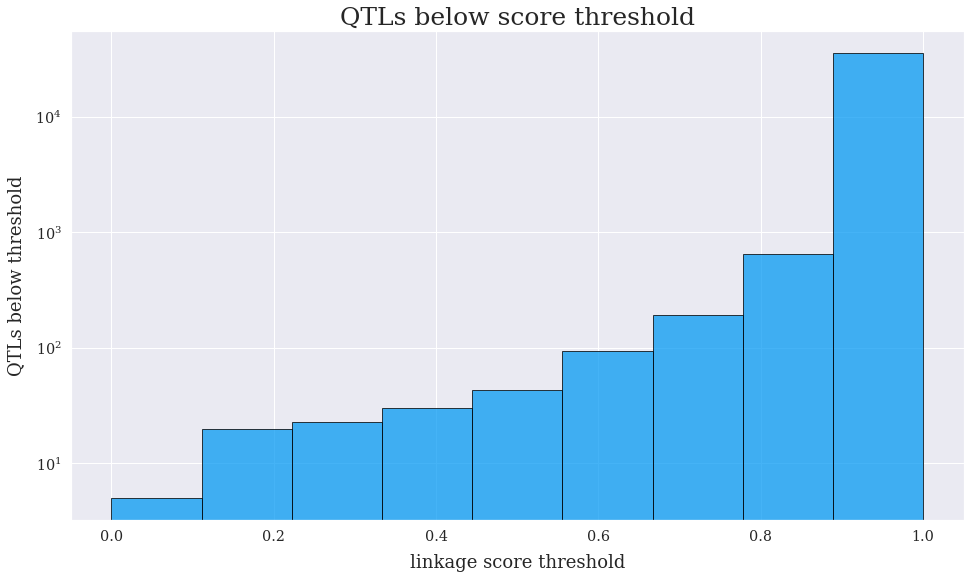

In [16]:
score_thresholds = np.linspace(0.8, 1, 10) # chosen empirically
sns.set(style="darkgrid", font_scale=1.3)
sns.set_style({"font.family": "serif"})
fig = plt.figure(figsize=(16,9));
plt.title("QTLs below score threshold", fontsize=25);
plt.xlabel("linkage score threshold", fontsize=18, labelpad=10);
plt.ylabel("QTLs below threshold", fontsize=18, labelpad=10);
plt.yscale("log")
plt.hist(qtls_df["eQTLs_2018"]["A&B"].score, 
         bins=np.linspace(0,1,10), 
         alpha=0.75,
         color="xkcd:azure", 
         edgecolor="black");

In [15]:
with open("data/tmp/figure-1/type2simulation_results_A&B_eQTLs_2018.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)

In [ ]:
# """ Run simulations from scratch and dump results on disk. """

# type2simulation_results = {}
# assert np.all(score_thresholds == np.linspace(0.8, 1, 10))
# for edge_type in tqdm_notebook(interaction_categories):
#     print(edge_type)
# #     if edge_type in ["all", "genetic", "physical"]:
# #         continue
#     rptest = RandomPairsTest(type2interactome[edge_type], 
#                              qtls_df["eQTLs_2018"]["A&B"],
#                              score_thresholds,
#                              max_iter=128, 
#                              n_jobs=min(32, score_thresholds.size))
#     type2simulation_results[edge_type] = rptest.map_reduce()

In [44]:
# with open("data/tmp/figure-1/type2simulation_results_A&B_eQTLs_2018.pkl", "wb") as outfile:
#     pickle.dump(type2simulation_results, outfile)

additive genetic interaction defined by inequality
suppressive genetic interaction defined by inequality
synthetic genetic interaction defined by inequality
association
colocalization
direct interaction
physical association
all
physical
genetic


In [51]:
# with open("data/processed/figures/figure-1/type2simulation_results_A&B_eQTLs_2018.pkl", "wb") as outfile:
#     pickle.dump(type2simulation_results, outfile)

## Visualizing results

### Broad interaction types: physical and genetic

In [14]:
def plot_figure_1(fig, gs, ax, type2interactome, type2simulation_results, 
                  interaction_categories, score_thresholds, suptitle, caption, colors, xscale_log=False):
    """
    This figure illustrates the observation that interacting genes tend
    to share more linkages than gene pairs selected uniformly at random
    
    Initially implemented 16.03.2019. 
    Usage examples can be found in figure-1.ipynb (look for relevant commits)
    -------------------------------------------------------------------------
    @param fig — matplotlib figure
    @param gs — matplotlib.gridspec — GridSpec object associated with fig
    @param ax — matplotlib axis — axis associated with gs
    @param type2interactome — dict(str, igraph.Graph)
        interactomes associated with different interaction categories
    @param type2simulation_results — dict of dicts 
        RandomPairsTest result
    @param interacton_categories — list(str) — categories to plot
    @param score_thresholds — list(float) — thresholds for linkage filtration
    @param suptitle — str — title for fig
    @param caption — str — caption for fig
    @param colors — dict(str, str) — colors for each interaction category
    -------------------------------------------------------------------------
    @example: 
        fig = plt.figure(figsize=(20,10))
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
        ax = plt.subplot(gs[0]), plt.subplot(gs[1])

        plot_figure_1(
            fig, gs, ax, type2interactome, type2simulation_results, 
            interaction_categories=["all", "genetic", "physical"],
            score_thresholds=score_thresholds,
            colors={"all" : "black",
                    "genetic" : "xkcd:azure", 
                    "physical" : "xkcd:tangerine"},
            suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
                     "genetic and physical interactions, QTLs from Albert and Bloom", 
            caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
                    "Star label stands for significantly different distributions of real and simulated "
                    "Jaccard linkage similarity coefficients.\n"
                    "The distributions were compared by MWU test on each randomization iteration. "
                    "Median p-value was used to assess significance."
        )
    -------------------------------------------------------------------------
    @todo introduce more flexibility to figure aesthetics specification
    """
    assert (np.intersect1d(interaction_categories, list(type2interactome.keys())).size 
            == len(interaction_categories)),\
            "some passed categories are not present in simulation results: {}".format(
                np.setdiff1d(interaction_categories, list(type2interactome.keys()))
            )
    assert (np.intersect1d(interaction_categories, list(type2simulation_results.keys())).size 
            == len(interaction_categories)),\
            "some passed categories are not present in simulation results: {}".format(
                np.setdiff1d(interaction_categories, list(type2simulation_results.keys()))
            )
    
    sns.set(style="darkgrid", font_scale=1.3)
    sns.set_style({'font.family':'serif'})
    
    fig.subplots_adjust(bottom=0.2, top=0.85, wspace=0.1)
    fig.suptitle(suptitle, fontsize=25)
    fig.align_labels(axs=ax)
    fig.text(0.5, 0.025, caption, wrap=True, horizontalalignment='center', fontsize=18)

    ax[0].set_title("Edges with linkages", fontsize=22, pad=10)
    ax[0].set_xlabel("linkage score threshold", fontsize=22, labelpad=10)
    ax[0].set_ylabel("number of edges", fontsize=22, labelpad=10)
    ax[0].yaxis.set_label_position("left")
    ax[0].ticklabel_format(style='sci', axis='y')
    if xscale_log: ax[0].set_xscale("log")

    # ax[1].set_yscale("log")
    # ax[1].yaxis.grid(False)
    # ax[1].set_yticks(10 ** np.array([4, 4.5, 5, 5.5, 6]))
    # ax[1].set_yticklabels(r"$10^{{{}}}$".format(i) for i in np.array([4, 4.5, 5, 5.5, 6]))
    
    ax[1].set_title("Linkage similarity by score threshold", fontsize=22, pad=10)
    ax[1].set_xlabel("linkage score threshold", fontsize=22, labelpad=10)
    ax[1].set_ylabel("average linkage similarity", fontsize=22, labelpad=10)
    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.tick_right()
    if xscale_log: ax[1].set_xscale("log")
    
    for edge_type in interaction_categories:
        simulation_results = type2simulation_results[edge_type]
        significant_point_ids = list(np.where(np.ravel(simulation_results["p-value"]) <= 0.05))
        
        ax[0].plot(score_thresholds, 
           simulation_results["actual"]["edge-has-linkages"]["mean"], 
           label="{} nodes ({:.2f}%)\n{} edges ({:.2f}%)".format(
               type2interactome[edge_type].vcount(),
               100 * round(type2interactome[edge_type].vcount()
                           / type2interactome["all"].vcount(), 4),
               type2interactome[edge_type].ecount(),
               100 *round(type2interactome[edge_type].ecount()
                          / type2interactome["all"].ecount(), 4),
           ),
           color=colors[edge_type], 
           marker="*",
           linestyle="-.",
           markevery=significant_point_ids,
           markerfacecolor="gold",
           markersize=15)
        ax[0].plot(score_thresholds, 
                   simulation_results["random"]["edge-has-linkages"]["50%"], 
                   color=colors[edge_type])
        ax[0].fill_between(score_thresholds, 
                     simulation_results["random"]["edge-has-linkages"]["25%"],  
                     simulation_results["random"]["edge-has-linkages"]["75%"], 
                     color=colors[edge_type], alpha=0.25)

        legend = ax[0].legend(loc="upper left", fontsize=15);
        frame = legend.get_frame();
        frame.set_facecolor("white");
        frame.set_edgecolor("black");
        ax[0].ticklabel_format(style='sci', axis='y', scilimits=(-3,3))
        
        ax[1].plot(score_thresholds, 
                 simulation_results["actual"]["linksim"]["mean"], 
                 label="{}".format(edge_type), 
                 color=colors[edge_type],
                 linestyle="-.",
                 marker="*",
                 markevery=significant_point_ids,
                 markerfacecolor="gold",
                 markersize=15)
        ax[1].plot(score_thresholds, 
                 simulation_results["random"]["linksim"]["50%"], 
                 c=colors[edge_type])
        ax[1].fill_between(score_thresholds, 
                         simulation_results["random"]["linksim"]["25%"],  
                         simulation_results["random"]["linksim"]["75%"], 
                         color=colors[edge_type], alpha=0.25)

        legend = ax[1].legend(loc="upper left", fontsize=15);
        frame = legend.get_frame();
        frame.set_facecolor("white");
        frame.set_edgecolor("black");
        ax[1].ticklabel_format(style='sci', axis='y', scilimits=(-2,2))
        

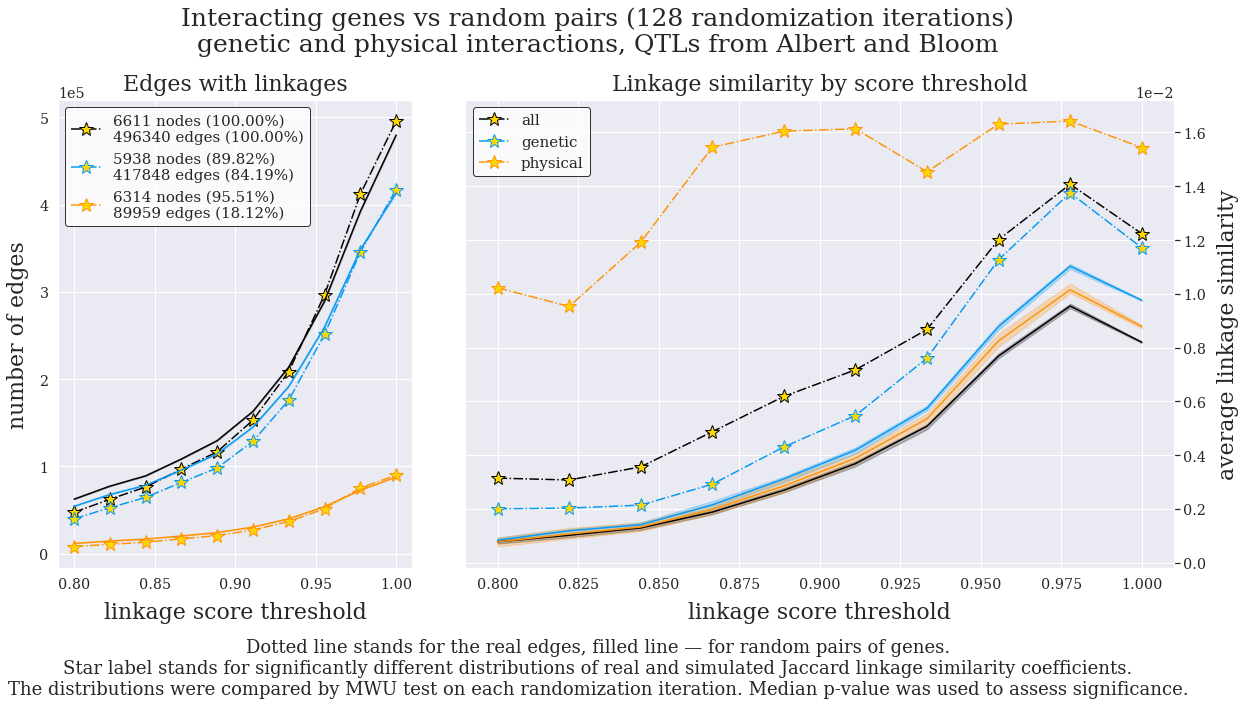

In [46]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=["all", "genetic", "physical"],
    score_thresholds=score_thresholds,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "genetic and physical interactions, QTLs from Albert and Bloom", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values."
)

### Narrower interaction types: subcategories

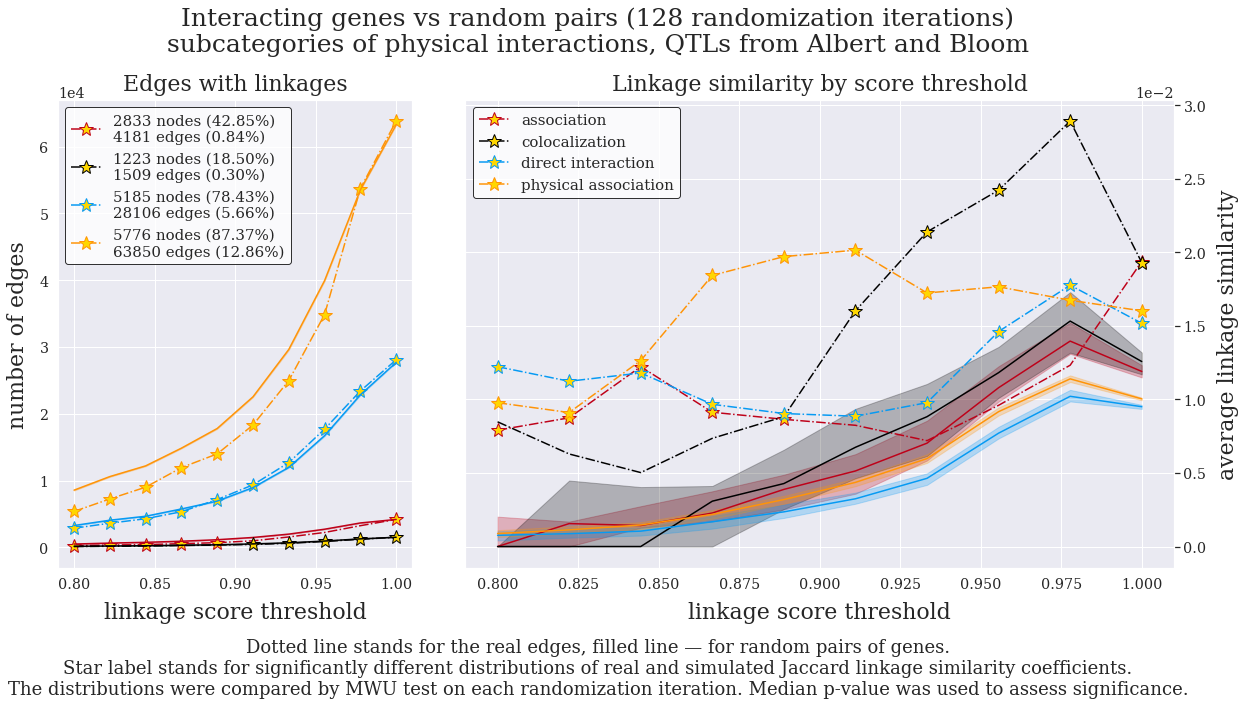

In [47]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=physical_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(physical_interaction_categories, 
                    ["xkcd:scarlet", "black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "subcategories of physical interactions, QTLs from Albert and Bloom", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values."
)

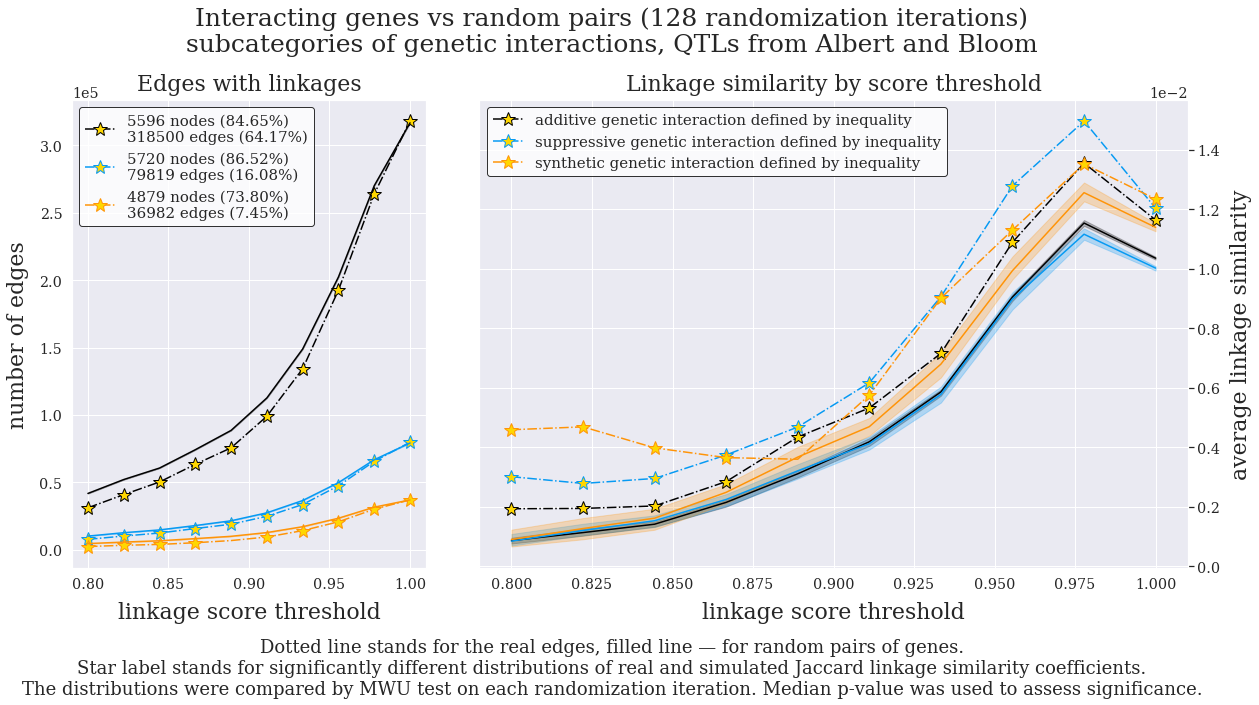

In [48]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=genetic_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(genetic_interaction_categories, 
                    ["black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "subcategories of genetic interactions, QTLs from Albert and Bloom", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values."
)

## Same data, limix algorithm

In [15]:
print("Total number of eQTLs: {}".format(qtls_df["eQTLs_2018"]["limix"].shape[0]))
qtls_df["eQTLs_2018"]["limix"].describe()

Total number of eQTLs: 106832


,p_value,q_value,score
count,1.068320e+05,1.068320e+05,1.068320e+05
mean,8.022888e-09,9.228736e-05,9.228736e-05
std,1.756186e-08,2.019994e-04,2.019994e-04
min,5.360848e-215,6.181058e-211,6.181058e-211
25%,1.942378e-15,2.236161e-11,2.236161e-11
50%,4.856658e-11,5.593144e-07,5.593144e-07
75%,4.791950e-09,5.515115e-05,5.515115e-05
max,8.704377e-08,9.999699e-04,9.999699e-04


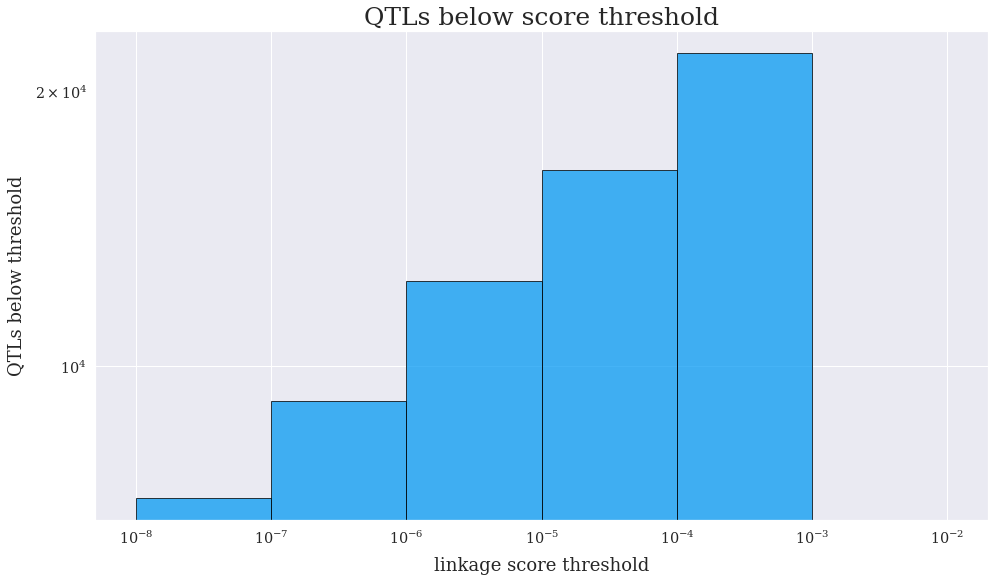

In [20]:
score_thresholds = 10. ** np.arange(-8, -1) # chosen empirically
sns.set(style="darkgrid", font_scale=1.3)
sns.set_style({"font.family": "serif"})
fig = plt.figure(figsize=(16,9)); 10. ** np.arange(-8, -1)
plt.title("QTLs below score threshold", fontsize=25);
plt.xlabel("linkage score threshold", fontsize=18, labelpad=10);
plt.ylabel("QTLs below threshold", fontsize=18, labelpad=10);
plt.yscale("log")
plt.xscale("log")
plt.hist(qtls_df["eQTLs_2018"]["limix"].score, 
         bins=score_thresholds, 
         alpha=0.75,
         color="xkcd:azure", 
         edgecolor="black");

In [ ]:
""" Run simulations from scratch and dump results on disk. """

type2simulation_results = {}
assert np.all(score_thresholds ==  10. ** np.arange(-8, -1))
for edge_type in tqdm_notebook(interaction_categories):
    print(edge_type)
    rptest = RandomPairsTest(type2interactome[edge_type], 
                             qtls_df["eQTLs_2018"]["limix"],
                             score_thresholds,
                             max_iter=128, 
                             n_jobs=min(32, score_thresholds.size))
    type2simulation_results[edge_type] = rptest.map_reduce()

additive genetic interaction defined by inequality
suppressive genetic interaction defined by inequality


In [ ]:
with open("data/processed/figures/figure-1/type2simulation_results_limix_eQTLs_2018.pkl", "wb") as outfile:
    pickle.dump(type2simulation_results, outfile)

In [ ]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=["all", "genetic", "physical"],
    score_thresholds=score_thresholds,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "genetic and physical interactions, data from Albert and Bloom, limix algorithm", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values."
)

In [ ]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=physical_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(physical_interaction_categories, 
                    ["xkcd:scarlet", "black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "subcategories of physical interactions, data from Albert and Bloom, limix algorithm", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values."
)

In [ ]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=genetic_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(genetic_interaction_categories, 
                    ["black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "subcategories of genetic interactions, data from Albert and Bloom, limix algorithm", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values."
)

## Running tests on our old data: eQTLs, naive algorithm

In [10]:
print("Total number of eQTLs: {}".format(qtls_df["eQTLs_2011"]["naive"].shape[0]))
qtls_df["eQTLs_2011"]["naive"].describe()

Total number of eQTLs: 62377


,p_value,q_value,score
count,6.237700e+04,6.237700e+04,6.237700e+04
mean,7.680238e-05,1.343645e-02,1.343645e-02
std,1.000102e-04,1.512601e-02,1.512601e-02
min,3.128418e-19,2.350027e-13,2.350027e-13
25%,5.595611e-07,3.138648e-04,3.138648e-04
50%,2.418394e-05,6.782825e-03,6.782825e-03
75%,1.281548e-04,2.396245e-02,2.396245e-02
max,3.565327e-04,4.999883e-02,4.999883e-02


In [11]:
score_thresholds = 10. ** np.arange(-8, -1) # chosen empirically

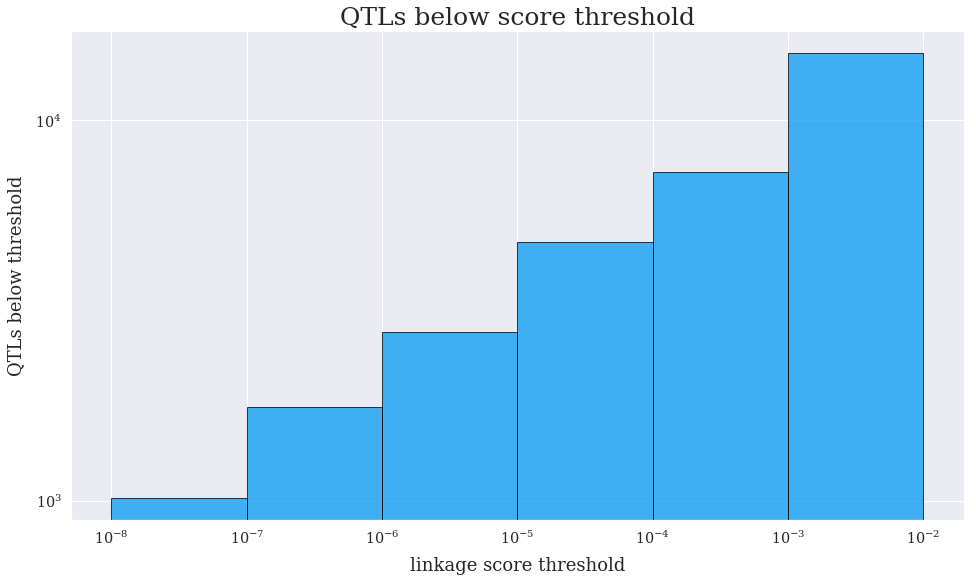

In [12]:
sns.set(style="darkgrid", font_scale=1.3)
sns.set_style({"font.family": "serif"})
fig = plt.figure(figsize=(16,9));
plt.title("QTLs below score threshold", fontsize=25);
plt.xlabel("linkage score threshold", fontsize=18, labelpad=10);
plt.ylabel("QTLs below threshold", fontsize=18, labelpad=10);
plt.yscale("log")
plt.xscale("log")
plt.hist(qtls_df["eQTLs_2011"]["naive"].q_value, 
         bins=score_thresholds, 
         alpha=0.75,
         color="xkcd:azure", 
         edgecolor="black");

In [52]:
with open("data/tmp/figure-1/type2simulation_results_naive_eQTLs_2011.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)

In [35]:
# """ Run simulations from scratch and dump results on disk. """

# # type2simulation_results = {}
# assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
# for edge_type in tqdm_notebook(interaction_categories):
#     if edge_type not in ["all", "genetic", "physical"]:
#         continue
#     print(edge_type)
# #     for edge_type in ["all", "genetic"]:
#     rptest = RandomPairsTest(type2interactome[edge_type], 
#                              qtls_df["eQTLs_2011"]["naive"],
#                              score_thresholds,
#                              max_iter=128, 
#                              n_jobs=min(32, score_thresholds.size))
#     type2simulation_results[edge_type] = rptest.map_reduce()

# # with open("data/tmp/figure-1/type2simulation_results_naive_eQTLs_2011.pkl", "wb") as outfile:
# #     pickle.dump(type2simulation_results, outfile)

all
physical
genetic


In [36]:
# with open("data/tmp/figure-1/type2simulation_results_naive_eQTLs_2011.pkl", "wb") as outfile:
#      pickle.dump(type2simulation_results, outfile)

In [53]:
# with open("data/processed/figures/figure_1/type2simulation_results_naive_eQTLs_2011.pkl", "wb") as outfile:
#      pickle.dump(type2simulation_results, outfile)

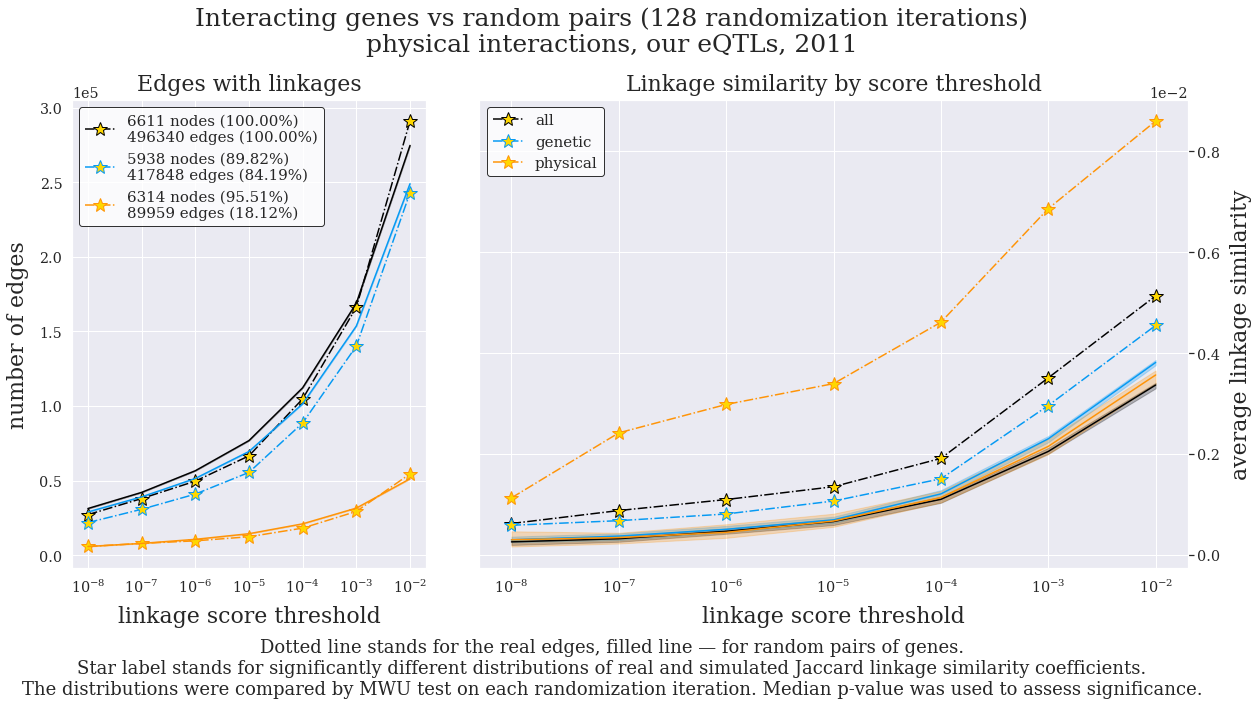

In [37]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=["all", "genetic", "physical"],
    score_thresholds=score_thresholds,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "genetic and physical interactions, our eQTLs, 2011", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

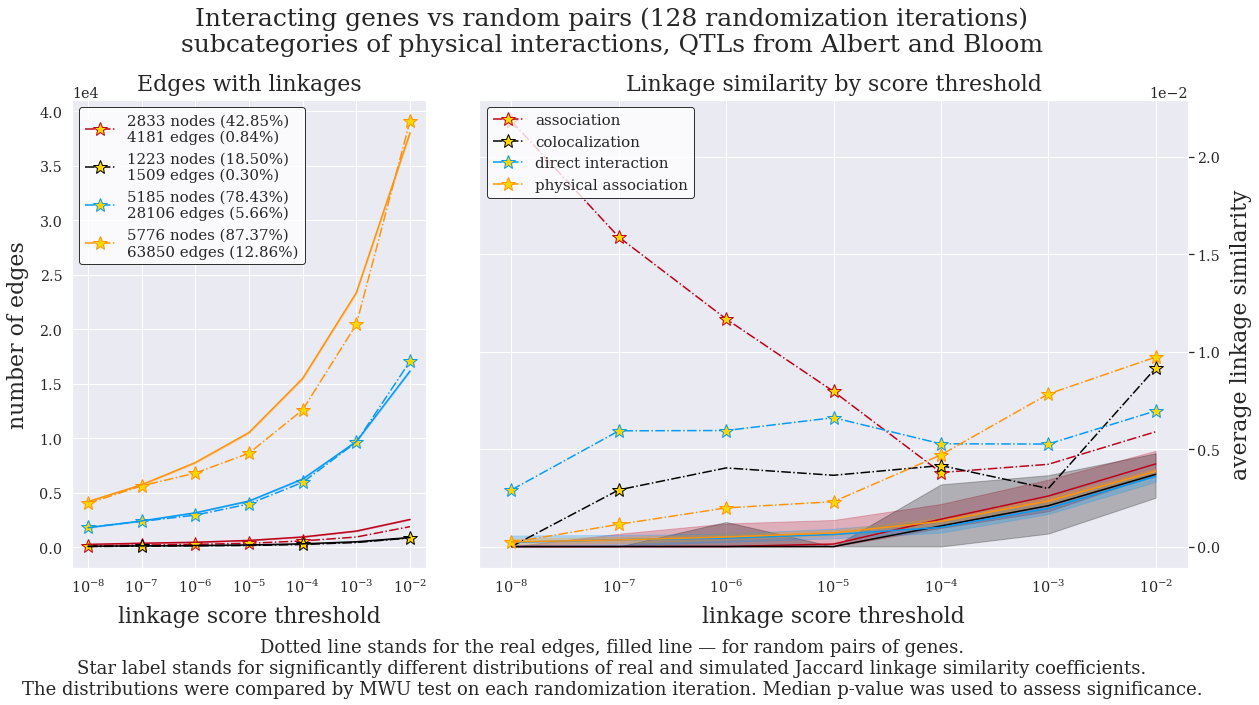

In [34]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=physical_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(physical_interaction_categories, 
                    ["xkcd:scarlet", "black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "subcategories of physical interactions, our eQTLs, 2011", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

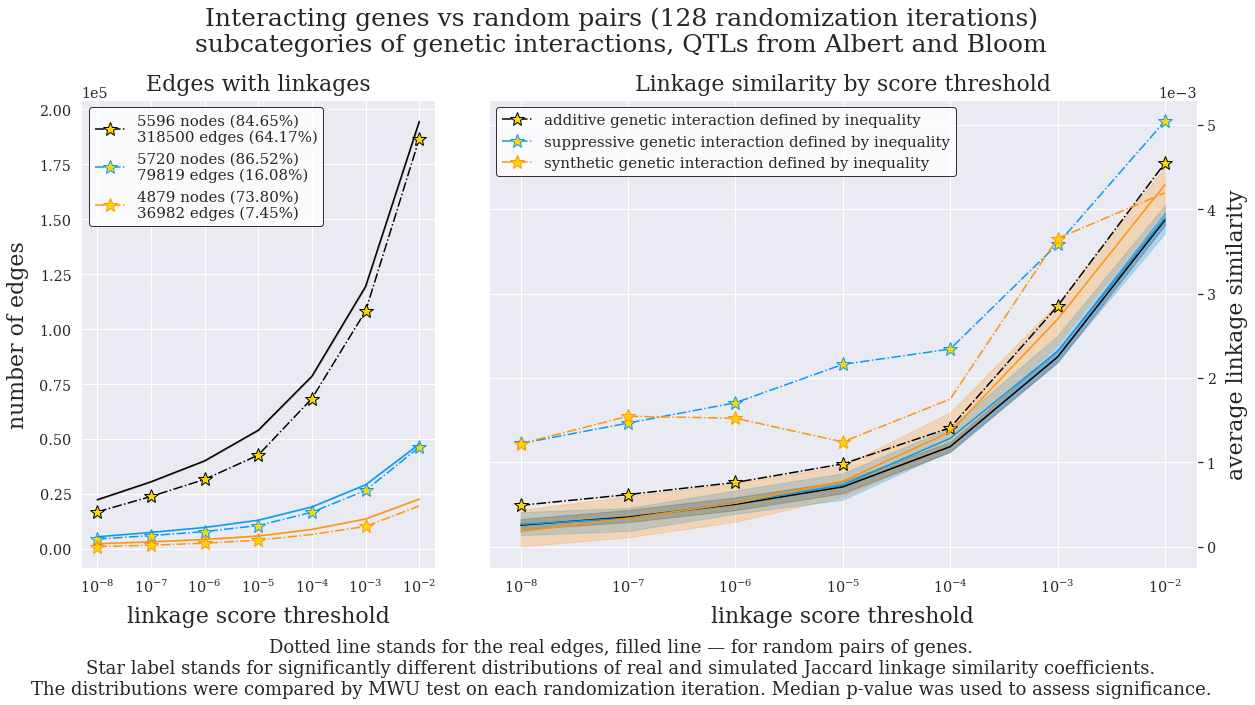

In [33]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=genetic_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(genetic_interaction_categories, 
                    ["black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "subcategories of genetic interactions, our eQTLs, 2011", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

## Running tests on our old data: pQTLs, naive algorithm

In [ ]:
with open("data/processed/figure-1/type2simulation_results_naive_pQTLs_2011.pkl", "rb") as infile:
    type2simulation_results = pickle.load(infile)

In [58]:
# """ Run simulations from scratch and dump results on disk. """

# type2simulation_results = {}
# assert np.all(score_thresholds == (10. ** np.arange(-8, -1)))
# for edge_type in tqdm_notebook(interaction_categories):
#     print(edge_type)
#     rptest = RandomPairsTest(type2interactome[edge_type], 
#                              qtls_df["pQTLs_2011"]["naive"],
#                              score_thresholds,
#                              max_iter=128, 
#                              n_jobs=min(32, score_thresholds.size))
#     type2simulation_results[edge_type] = rptest.map_reduce()

additive genetic interaction defined by inequality
suppressive genetic interaction defined by inequality
synthetic genetic interaction defined by inequality
association
colocalization
direct interaction
physical association
all
physical
genetic


In [59]:
# with open("data/tmp/figure-1/type2simulation-results_naive_pQTLs_2011.pkl", "wb") as outfile:
#     pickle.dump(type2simulation_results, outfile)

In [63]:
# with open("data/processed/figures/figure-1/type2simulation_results_naive_pQTLs_2011.pkl", "wb") as outfile:
#     pickle.dump(type2simulation_results, outfile)

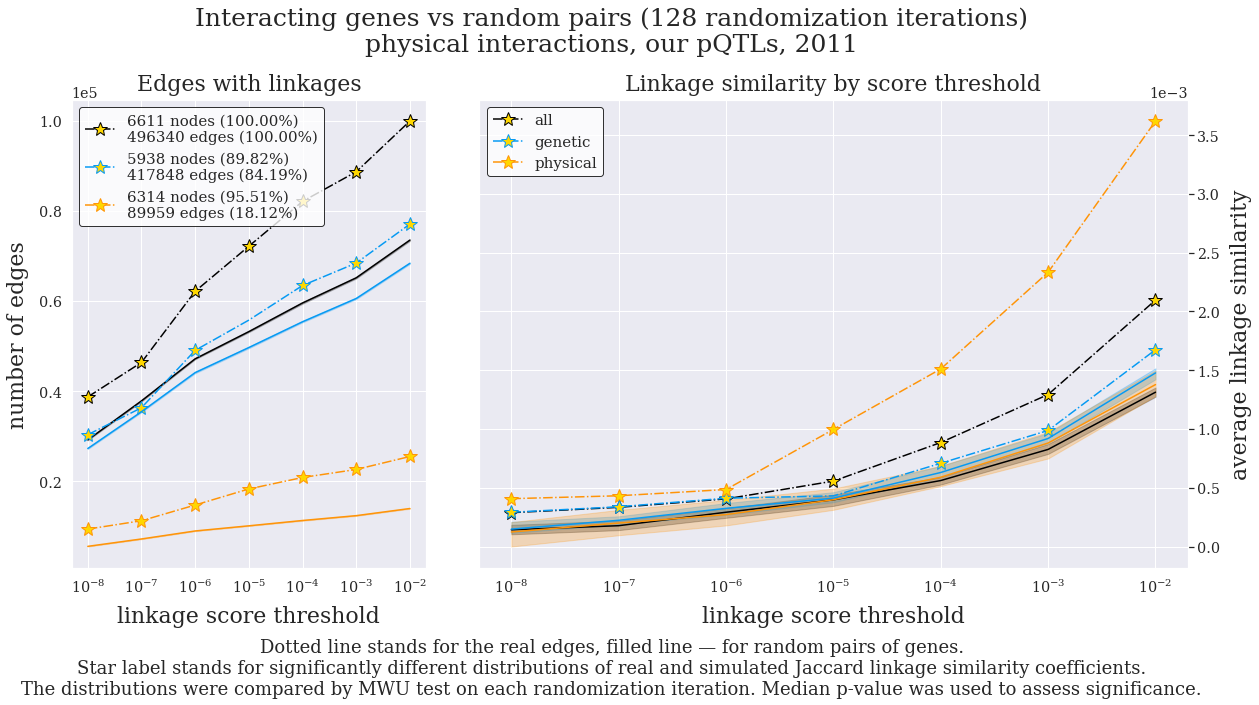

In [60]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=["all", "genetic", "physical"],
    score_thresholds=score_thresholds,
    colors={"all" : "black",
            "genetic" : "xkcd:azure", 
            "physical" : "xkcd:tangerine"},
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "physical interactions, our pQTLs, 2011", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

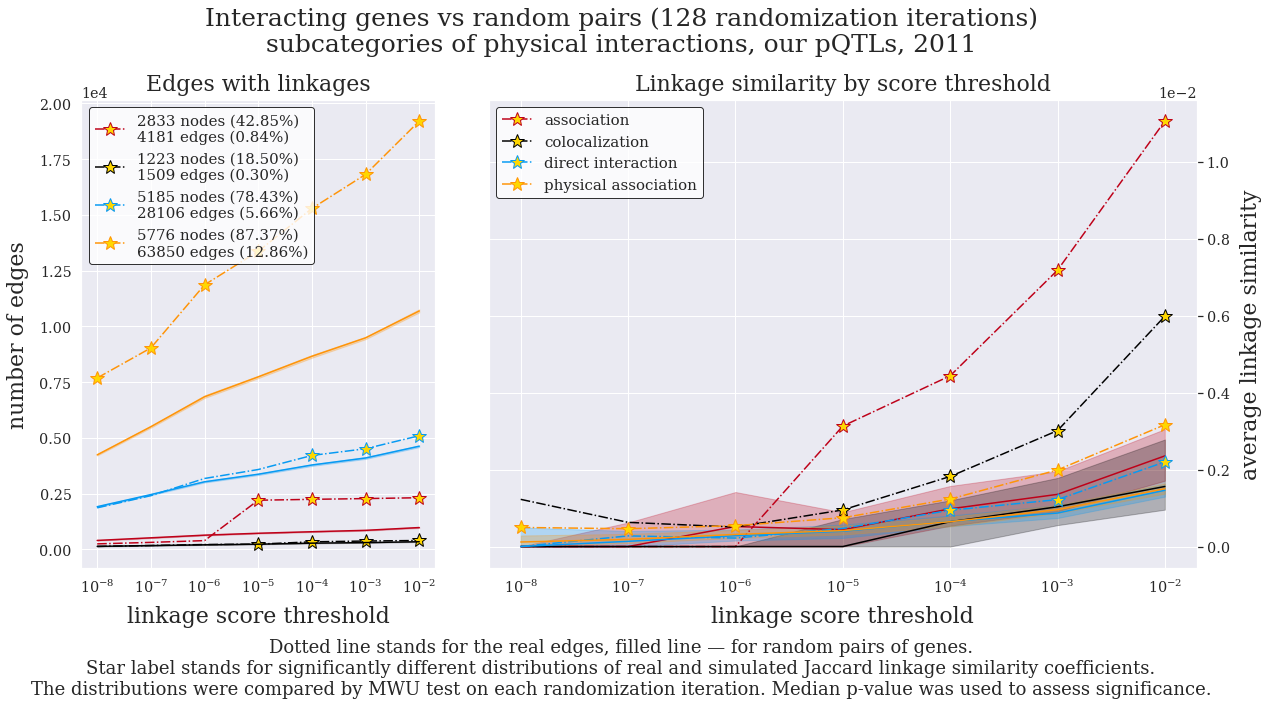

In [61]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=physical_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(physical_interaction_categories, 
                    ["xkcd:scarlet", "black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "subcategories of physical interactions, our pQTLs, 2011", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)

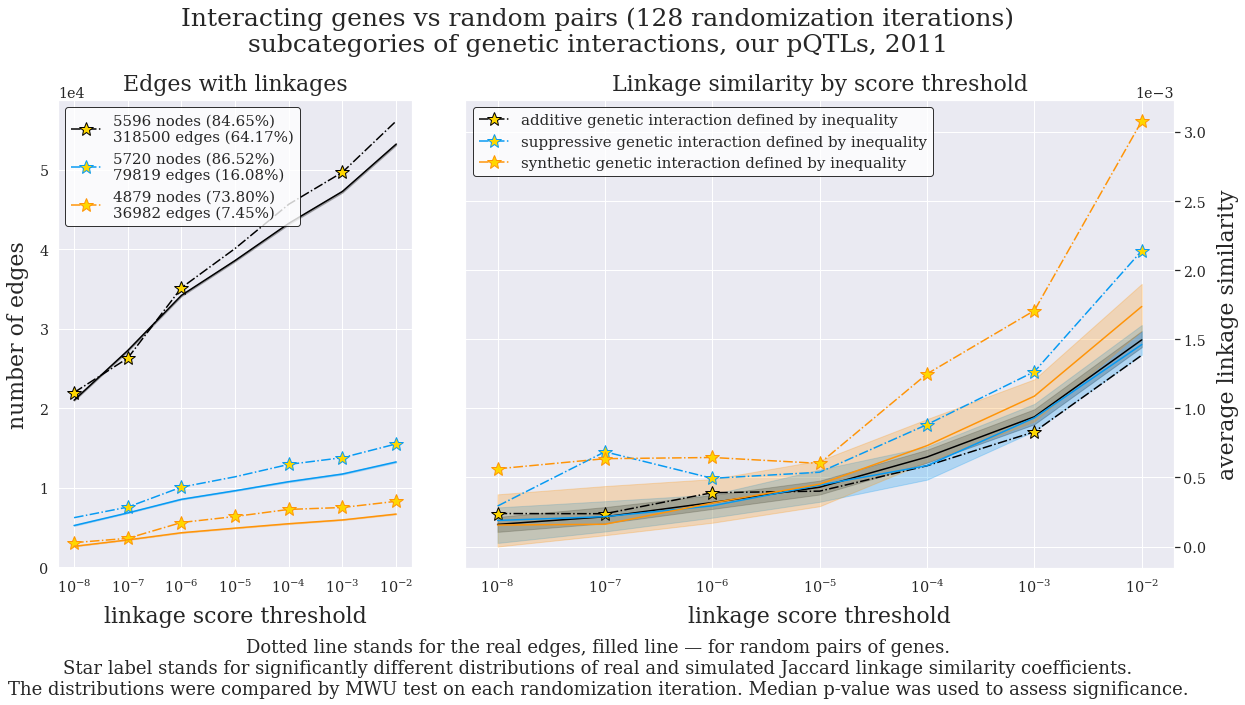

In [62]:
fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
ax = plt.subplot(gs[0]), plt.subplot(gs[1])

plot_figure_1(
    fig, gs, ax, type2interactome, type2simulation_results, 
    interaction_categories=genetic_interaction_categories,
    score_thresholds=score_thresholds,
    colors=dict(zip(genetic_interaction_categories, 
                    ["black", "xkcd:azure", "xkcd:tangerine"])),
    suptitle="Interacting genes vs random pairs (128 randomization iterations)\n"
             "subcategories of genetic interactions, our pQTLs, 2011", 
    caption="Dotted line stands for the real edges, filled line — for random pairs of genes.\n"
            "Star label stands for significantly different distributions of real and simulated "
            "Jaccard linkage similarity coefficients.\n"
            "The distributions were compared by MWU test on each randomization iteration. "
            "Fisher's method was used to combine p-values.",
    xscale_log=True
)